# Query Intent Recognizer - Binary Classifier
- **Feature:** User Query
- **Label:** database_query, non_database_query

In [ ]:
import json
import random
import re
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from transformers import BertTokenizer, TFBertModel


In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Collection and Loading

In [ ]:
# Helper Function: Load queries into DataFrames
def load_queries_jsonl(file_path):
  queries = []
  with open(file_path, 'r') as f:
    for line in f:
      item = json.loads(line.strip())
      queries.append({
        'question': item['question'],
      })
  return pd.DataFrame(queries)

In [ ]:
# Load wikisql dataset
data_dir='/content/drive/MyDrive/wikisql_data'
train_path = os.path.join(data_dir, 'train.jsonl')

train_data = load_queries_jsonl(train_path)
train_data.head()

,question
0,Tell me what the notes are for South Australia
1,What is the current series where the new serie...
2,What is the format for South Australia?
3,Name the background colour for the Australian ...
4,how many times is the fuel propulsion is cng?


In [ ]:
train_data.shape

(56355, 1)

In [ ]:
train_data = train_data.sample(50000, replace=False)
train_data['label'] = "database_query"

In [ ]:
print(train_data.shape)
train_data.head()

(50000, 2)


,question,label
21700,"Which average Long has a Gain smaller than 16,...",database_query
38811,What system has a current version of 1.4e?,database_query
5462,Name march 27-29 where january 15-16 is januar...,database_query
16033,Tell me the player for pick number less than 2...,database_query
39870,What number of win% has a postseason of did no...,database_query


## Data Preprocessing

In [ ]:
from sentence_transformers import SentenceTransformer

# Load pre-trained model
embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode queries
db_embeddings = embedder.encode(train_data["question"], convert_to_numpy=True)

In [ ]:
import numpy as np

def split_array(arr, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True, seed=42):
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1."

    n = len(arr)
    indices = np.arange(n)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)

    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]

    return arr[train_idx], arr[val_idx], arr[test_idx]

In [ ]:
# Split into train, val, test
train_data, val_data, test_data = split_array(db_embeddings)

In [ ]:
# Check shape
train_data.size/384 , val_data.size/384, test_data.size/384

(39448.0, 8453.0, 8454.0)

In [ ]:
# Check structure
train_data[0]

In [ ]:
# Dummies Negative Samples #1 for validation and testing
import random

def generate_negative_samples(n=8454, seed=42):
    random.seed(seed)

    # Intent categories with example templates
    templates = {
        "greeting": [
            "Hello", "Hi there", "Good morning", "How are you?", "What's up?", "How do you do?", "Good afternoon", "It's you!", "How is your day?"
        ],
        "weather": [
            "What's the weather like today?",
            "Will it rain tomorrow?",
            "Show me the forecast for this weekend.",
            "What's a hot day!",
            "A very cold weather today.",
            "Please rain right now."
        ],
        "joke": [
            "Tell me a joke.",
            "Make me laugh.",
            "Do you know any funny stories?",
            "Provide me a cold joke.",
            "Make me fun.",
            "Hahahahahah"
        ],
        "music": [
            "Play some jazz music.",
            "Can you recommend a good song?",
            "Start my workout playlist.",
            "Do you like to play music?",
            "What kinds of music is suitable for me?",
            "Music is good or bad?"
        ],
        "translate": [
            "Translate 'thank you' to Spanish.",
            "How do you say 'hello' in French?",
            "What's the Chinese word for love?",
            "Tell me 'Oh my god' in Malay.",
            "Do you speak English?",
            "Happy Chinese"
        ],
        "personal": [
            "Set a reminder for my meeting at 3 PM.",
            "What's on my schedule today?",
            "Call mom.",
            "Remember to wake me up tomorrow.",
            "How can I plan for tomorrow routine?"
        ],
        "general_knowledge": [
            "Who is the president of the US?",
            "When was the Eiffel Tower built?",
            "What is the speed of light?",
            "What is the highest mountain in the world?",
            "When is the Chinese New Year?"
        ],
        "random_request": [
            "Open the camera app.",
            "Take a screenshot.",
            "Show me nearby restaurants.",
            "Scroll the screen.",
            "Next page."
        ],
        "math": [
            "What is 123 times 456?",
            "Solve the equation x^2 + 2x + 1 = 0",
            "What's the square root of 64?",
            "3 + 3 equals ?",
            "1000000 is the factor of 10?"
        ]
    }

    # Flatten all templates
    all_templates = []
    for intent, items in templates.items():
        all_templates.extend(items)

    # Expand and vary the list
    generated = []
    while len(generated) < n:
        base = random.choice(all_templates)
        variation = base

        # Add minor variations
        if "?" in base and random.random() < 0.3:
            variation = base.replace("?", " please?")
        elif random.random() < 0.2:
            variation = "Hey, " + base.lower()

        generated.append(variation)

    return generated[:n]

# Generate 8454 negative samples
negative_samples = generate_negative_samples(4000)

# Example preview
for i in range(5):
    print(f"{i+1}. {negative_samples[i]}")


1. What is the speed of light please?
2. Next page.
3. Hey, please rain right now.
4. Good afternoon
5. What's on my schedule today please?


In [ ]:
# Dummies Negative Samples #2 for testing only
def generate_non_database_queries(num_samples):
    non_db_templates = [
        "What time is it?",
        "How are you today?",
        "Tell me a joke.",
        "What’s the weather like in {city}?",
        "Can you help me with something?",
        "How do I cook {food}?",
        "What’s the meaning of life?",
        "Tell me about {topic}.",
        "Who won the {event}?",
        "What’s the best {item} to buy?",
        "How do I fix a {problem}?",
        "What’s the history of {place}?",
        "Can you recommend a {media} to watch?",
        "What’s the difference between {thing1} and {thing2}?",
        "How do I learn {skill}?",
        "What’s the population of {city}?",
        "Who is the president of {country}?",
        "What’s the tallest {structure} in the world?",
        "How do I plan a trip to {place}?",
        "What’s the latest news on {topic}?",
        "Can you explain {concept} to me?",
        "What’s the recipe for {food}?",
        "How do I start a {hobby}?",
        "What’s the best way to save {resource}?",
        "Tell me a fun fact about {topic}."
    ]
    cities = ["New York", "London", "Tokyo", "Sydney", "Paris", "Berlin"]
    countries = ["France", "Brazil", "Japan", "Canada", "Australia", "India"]
    foods = ["pizza", "pasta", "sushi", "cake", "salad", "soup"]
    topics = ["space", "history", "technology", "music", "science", "art"]
    events = ["Super Bowl", "World Cup", "Olympics", "Oscars", "Grammys"]
    items = ["phone", "laptop", "car", "book", "headphones"]
    problems = ["leaky faucet", "flat tire", "slow computer", "broken chair"]
    places = ["Rome", "Egypt", "California", "Antarctica"]
    media = ["movie", "TV show", "book", "podcast"]
    things = ["dogs and cats", "coffee and tea", "laptops and tablets"]
    skills = ["coding", "painting", "guitar", "photography"]
    structures = ["building", "bridge", "mountain"]
    concepts = ["gravity", "blockchain", "photosynthesis"]
    hobbies = ["gardening", "hiking", "knitting", "birdwatching"]
    resources = ["money", "time", "energy", "water"]

    non_db_queries = []
    for _ in range(num_samples):
        template = random.choice(non_db_templates)
        query = template.format(
            city=random.choice(cities),
            country=random.choice(countries),
            food=random.choice(foods),
            topic=random.choice(topics),
            event=random.choice(events),
            item=random.choice(items),
            problem=random.choice(problems),
            place=random.choice(places),
            media=random.choice(media),
            thing1=random.choice(things).split(" and ")[0],
            thing2=random.choice(things).split(" and ")[1],
            skill=random.choice(skills),
            structure=random.choice(structures),
            concept=random.choice(concepts),
            hobby=random.choice(hobbies),
            resource=random.choice(resources)
        )
        non_db_queries.append(query)
    return non_db_queries

# Generate 4454 negative samples
negative_samples_2 = generate_non_database_queries(4454)

# Example preview
for i in range(5):
    print(f"{i+1}. {negative_samples_2[i]}")

1. Who is the president of Canada?
2. Tell me a fun fact about space.
3. How do I learn coding?
4. What time is it?
5. What’s the recipe for soup?


In [ ]:
# Encode NDQ queries
neg_val_data = negative_samples[:2000] + negative_samples_2[:2227]
neg_test_data = negative_samples[2000:] + negative_samples_2[2227:]

neg_val_embeddings = embedder.encode(neg_val_data, convert_to_numpy=True)
neg_test_embeddings = embedder.encode(neg_test_data, convert_to_numpy=True)

In [ ]:
neg_val_embeddings.size/384 , neg_test_embeddings.size/384

(8227.0, 227.0)

In [ ]:
# Add into val and test
val_data_mixed = np.concatenate([val_data, neg_val_embeddings], axis=0)
test_data_mixed = np.concatenate([test_data, neg_test_embeddings], axis=0)

## Model Training
1. One Class SVM

In [ ]:
from sklearn.svm import OneClassSVM

# Initialize and train One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
svm_model.fit(train_data)

OneClassSVM(gamma='auto', nu=0.1)

In [ ]:
from sklearn.metrics import classification_report

# Evaluation
X_val = val_data_mixed.tolist()
y_val = [1] * len(val_data) + [-1] * len(neg_val_embeddings)

# Predict
y_pred = svm_model.predict(X_val)

print(classification_report(y_val, y_pred, target_names=["non-dbq", "dbq"]))

              precision    recall  f1-score   support

     non-dbq       0.89      0.83      0.86      8227
         dbq       0.84      0.90      0.87      8453

    accuracy                           0.86     16680
   macro avg       0.87      0.86      0.86     16680
weighted avg       0.86      0.86      0.86     16680



In [ ]:
from sklearn.metrics import classification_report

best_nu = None
best_f1 = 0.0
for nu in [0.01, 0.05, 0.1, 0.2]:
    model = OneClassSVM(kernel='rbf', gamma='auto', nu=nu)
    model.fit(train_data)
    preds = model.predict(val_data_mixed)
    y_true = [1] * len(val_data) + [-1] * len(neg_val_embeddings)
    f1 = (preds == y_true).sum() / len(y_true)
    print(f"nu={nu} | F1 (simulated) = {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_nu = nu

print(f"Best nu: {best_nu}")

nu=0.01 | F1 (simulated) = 0.7562350119904077
nu=0.05 | F1 (simulated) = 0.8547961630695443
nu=0.1 | F1 (simulated) = 0.8633093525179856
nu=0.2 | F1 (simulated) = 0.8412470023980816
Best nu: 0.1


In [ ]:
from sklearn.svm import OneClassSVM

# Initialize and train One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=best_nu)
svm_model.fit(train_data)

OneClassSVM(gamma='auto', nu=0.1)

In [ ]:
from sklearn.metrics import classification_report

# Combine test set
X_test = test_data_mixed.tolist()
y_true = [1] * len(test_data) + [-1] * len(neg_test_embeddings)

# Predict
y_pred = svm_model.predict(X_test)

print(classification_report(y_true, y_pred, target_names=["non-dbq", "dbq"]))

              precision    recall  f1-score   support

     non-dbq       0.18      0.85      0.30       227
         dbq       1.00      0.90      0.94      8454

    accuracy                           0.89      8681
   macro avg       0.59      0.87      0.62      8681
weighted avg       0.97      0.89      0.93      8681




One Class SVM Confusion Matrix:
[[ 192   35]
 [ 877 7577]]


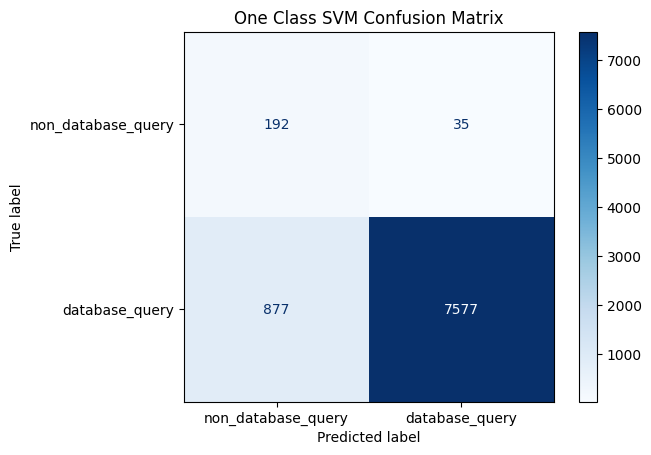

In [ ]:
# Confusion Matrix for One Class SVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ocSVM_cm = confusion_matrix(y_true, y_pred)
print("\nOne Class SVM Confusion Matrix:")
print(ocSVM_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=ocSVM_cm, display_labels=['non_database_query', 'database_query'])
disp.plot(cmap=plt.cm.Blues)
plt.title("One Class SVM Confusion Matrix")
plt.show()